In [9]:
### Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [10]:
## load data
data_dir = '../data'
df = pd.read_csv(f'{data_dir}/loan.csv', dtype = {'next_pymnt_d' : str})
df.shape

(39717, 111)

In [11]:
df.groupby(by = ['loan_status'])['total_rec_late_fee'].mean()

loan_status
Charged Off    4.291692
Current        1.172878
Fully Paid     0.869452
Name: total_rec_late_fee, dtype: float64

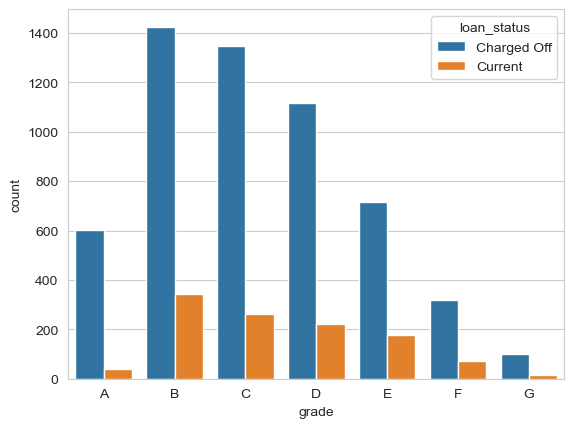

In [25]:
sns.countplot(data = df[df['loan_status'] != 'Fully Paid'], x = 'grade', hue = 'loan_status', order = 'A B C D E F G'.split())
plt.show()

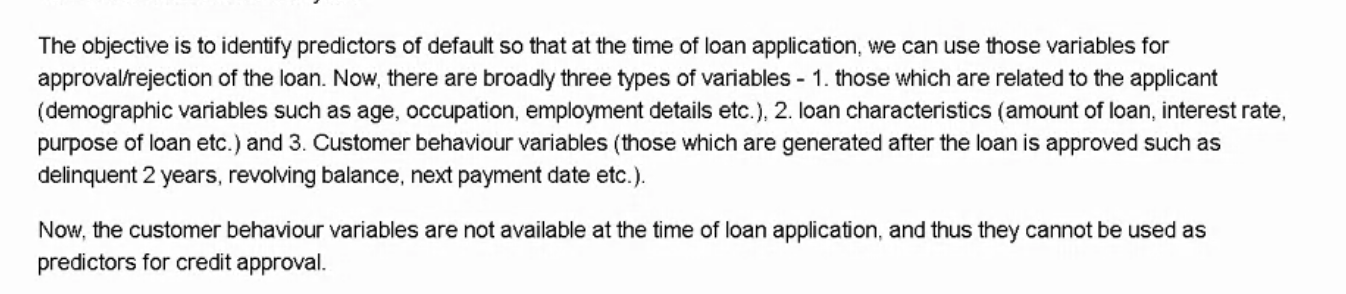

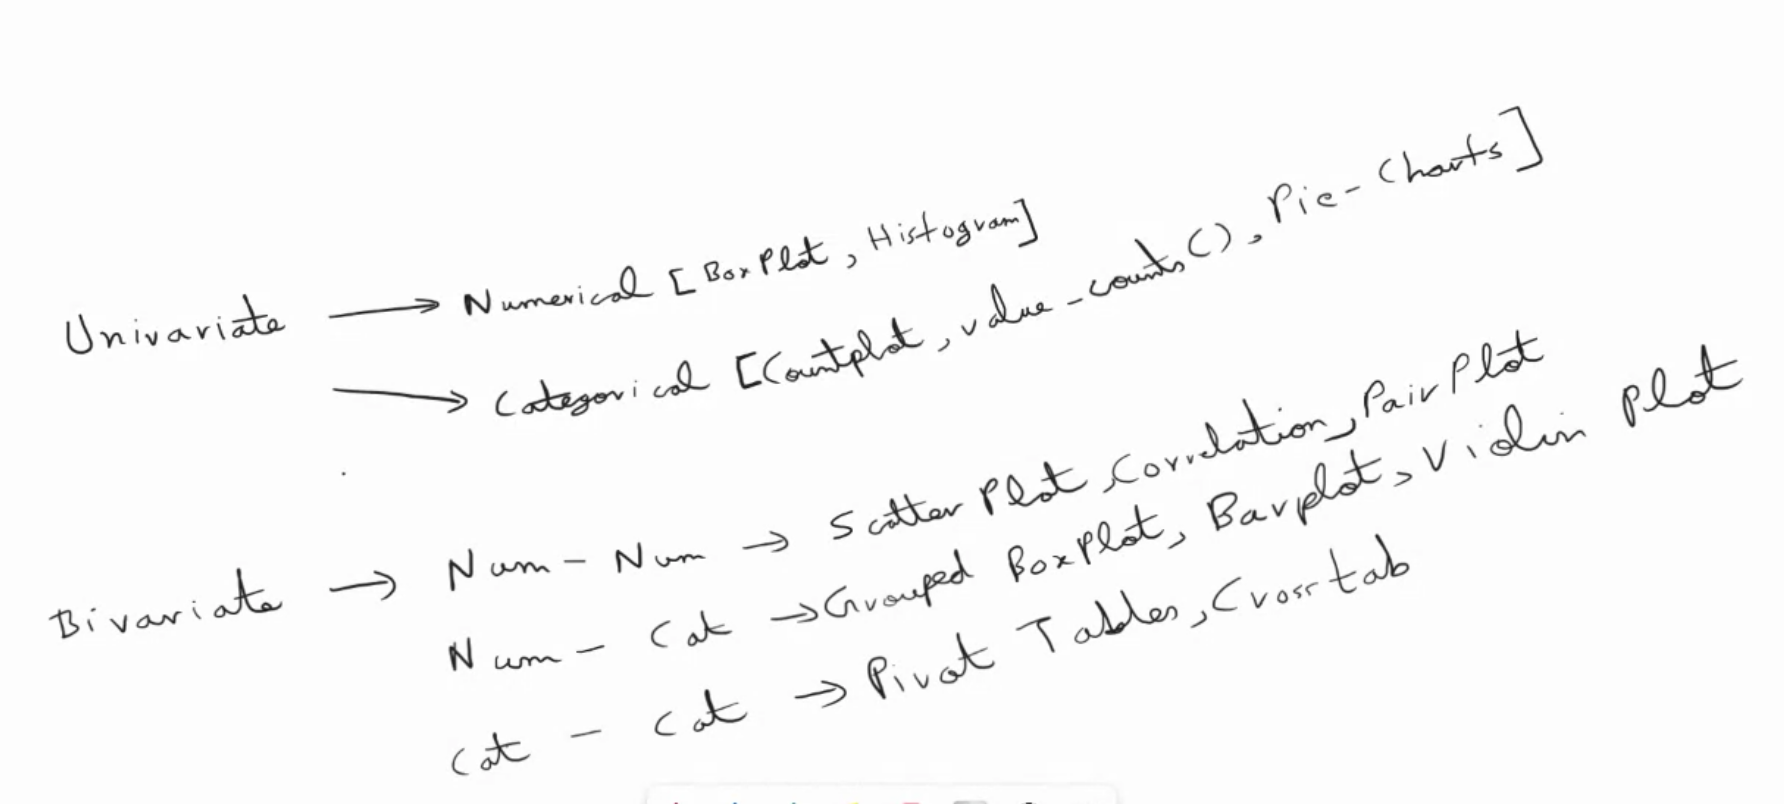

In [6]:
# drop_cols = df.dropna(axis = 1, how = 'all').columns
# [c for c in df.columns if c not in drop_cols]

In [ ]:
#df.dtypes.value_counts()
num_cols = df.dtypes[df.dtypes == float].index.tolist()
int_cols = df.dtypes[df.dtypes == int].index.tolist()
str_cols = df.dtypes[df.dtypes == object].index.tolist()

print('Num cols:', len(num_cols), '\nint cols:', len(int_cols), '\nstr cols:', len(str_cols))

### Explore target

- `Fully paid`: Applicant has fully paid the loan (the principal and the interest rate)
- `Current`: Applicant is in the process of paying the instalments, i.e. the tenure of the loan is not yet completed. These candidates are not labelled as 'defaulted'
- `Charged-off`: Applicant has not paid the instalments in due time for a long period of time, i.e. he/she has defaulted on the loan

In [ ]:
df['loan_status'].value_counts() / len(df)

Among all the customers over the years, 14% of them defaults and 3% of them paying the installments.

Let inspect the trend by issue data: year and then month

In [ ]:
df[['issue_month', 'issue_year']] = df.apply(lambda x: x['issue_d'].split('-'), axis = 1, result_type = 'expand')

# Map month to index for better sorting
month_idx_map = {l:i for i,l in enumerate(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], start=1)}
idx_month_map = {i:l for i,l in month_idx_map.items()}
df['issue_month'] = df['issue_month'].map(month_idx_map)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (9, 3))

sns.countplot(data = df, x = 'loan_status', ax = ax[0])
sns.countplot(data = df, x = 'issue_year', ax = ax[1])

ax[0].set_xlabel('Loan status')
ax[0].set_ylabel('Number of applicants')

ax[1].set_xlabel('Loan issued year')
ax[1].set_ylabel('Number of applicants')

plt.tight_layout()

plt.show()

In [ ]:
total_df = df.groupby(by = ['issue_year'])['id'].agg('count').reset_index()
total_df.rename(columns = {'id' : 'total'}, inplace = True)

loan_df = df.groupby(by = ['issue_year', 'loan_status'])['id'].agg('count').reset_index()
loan_df.rename(columns = {'id' : 'count'}, inplace = True)

loan_df = loan_df.merge(total_df, on = ['issue_year'])
loan_df['pct'] = loan_df['count'] / loan_df['total']


sns.barplot(data = loan_df, x = 'issue_year', y = 'pct', hue = 'loan_status')
plt.show()

Proportion of default loan dropped considerably until 2009 and the trend shifted in 2010. 

### DATA CLEANUP

In [ ]:
def cleanup(df):
    
    # interest rate
    df['int_rate'] = df['int_rate'].apply(lambda x: float(x.replace('%', '')))

    # loan term - all are in months so no conversion is need
    df['term'] = df['term'].apply(lambda x: int(x.split()[0]))
    
    return df

<b>Questions to explore</b>
1. Factors influencing the default loan in general
2. What factors tipped increase in defaults in 2010 / 2011

### Lets start with the second question
What factors tipped increase in defaults in 2011 (in specific)? Later we will see if the factors generalize well. 

Notes:
- Over the years, the applicants increased exponenetially and the shift in trend could be an artifact.
- The economy was in great recession in the selected timeperiod and it might have an influence.

In [ ]:
data = cleanup(df[df['issue_year'] == '11'])
df.shape, data.shape

Inspect correlation between defaults and interest rate 

In [ ]:
sns.histplot(data = data, hue = 'loan_status', x = 'int_rate', bins = 60, kde = True)
plt.show()

Defaults are pretty much independent of interest rate. 

LOAN Amount to annual income

In [ ]:
data['loan_to_income'] = data['loan_amnt'] / data['annual_inc']

In [ ]:
sns.histplot(data = data[(data['loan_status'] != 'Fully Paid') & (data['grade'] == 'C')],
             hue = 'loan_status', x = 'loan_to_income', y = 'int_rate')#, marker = '.')
plt.show()

Loan grade

In [ ]:
sns.countplot(data = data, x = 'grade', hue = 'loan_status')
plt.show()